In [176]:
import pandas as pd
print(pd.__version__)
import xlrd # this engine not needed under pandas 1.2 apparently

pd.set_option('precision', 3)
pd.set_option('max_columns', 50)

import datetime as dt

import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

import matplotlib.pyplot as plt

1.1.5


<div class="alert alert-success">

## SECTIONS

- [cleaning & wrangling](#wrangling)
    
- [examining hourly data quality](#wrangling_qual)
    
- [bikes](#bikes)
    
- [methodology](#method)
    
</div>

In [28]:
# read in the excel file downloaded from the site for my 'segment id'

file = 'telraam-raw-data-export-9000001132.xlsx'

dfpre = pd.read_excel(file, engine='openpyxl')

dfpre[:3]

# note, the data starts at 11am on Dec 1, not at the start of the day


,Segment Id,Date,Pct_up,Pedestrian (A > B / lft),Pedestrian (B > A / rgt),Pedestrian Total,Bike (A > B / lft),Bike (B > A / rgt),Bike Total,Car (A > B / lft),Car (B > A / rgt),Car Total,Large vehicle (A > B / lft),Large vehicle (B > A / rgt),Large vehicle Total,Speed Car 0-10 km/u,Speed Car 10-20 km/u,Speed Car 20-30 km/u,Speed Car 30-40 km/u,Speed Car Car 40-50 km/u,Speed Car 50-60 km/u,Speed Car 60-70 km/u,Speed Car 70+ km/u
0,9000001132,2020-12-01 11:00,0.512,2,2,4,8,6,14,16,4,20,0,0,0,30.00,50.00,10.0,10.0,0.00,0.00,0.0,0.0
1,9000001132,2020-12-01 12:00,0.758,1,4,5,12,4,16,21,11,32,0,0,0,8.33,33.33,37.5,12.5,4.17,4.17,0.0,0.0
2,9000001132,2020-12-01 13:00,0.770,1,5,6,14,4,18,17,9,26,0,0,0,10.00,30.00,25.0,30.0,5.00,0.00,0.0,0.0


<a id='wrangling'></a>
<div class="alert alert-success">

## cleaning & wrangling
</div>

In [29]:
# show shape of df and col names

print(dfpre.shape)

dfpre.columns


(1425, 23)


Index(['Segment Id', 'Date', 'Pct_up', 'Pedestrian (A > B / lft)',
       'Pedestrian (B > A / rgt)', 'Pedestrian Total', 'Bike (A > B / lft)',
       'Bike (B > A / rgt)', 'Bike Total', 'Car (A > B / lft)',
       'Car (B > A / rgt)', 'Car Total', 'Large vehicle (A > B / lft)',
       'Large vehicle (B > A / rgt)', 'Large vehicle Total',
       'Speed Car 0-10 km/u', 'Speed Car 10-20 km/u', 'Speed Car 20-30 km/u',
       'Speed Car 30-40 km/u', 'Speed Car Car 40-50 km/u',
       'Speed Car 50-60 km/u', 'Speed Car 60-70 km/u', 'Speed Car 70+ km/u'],
      dtype='object')

In [30]:
# make list of clean col names

col_list = ['segment', 'date_time', 'pct_up', 'pedestrian_ab', 'pedestrian_ba', 'ped_all', 'bike_ab', 
            'bike_ba', 'bike_all', 'car_ab', 'car_ba', 'car_all', 'big_veh_ab', 'big_veh_ba', 'big_veh_all',
            'car_speed_010k', 'car_speed_1020k', 'car_speed_2030k', 'car_speed_3040k', 'car_speed_4050k', 
            'car_speed_5060k', 'car_speed_6070k', 'car_speed_7080k']

In [31]:
# replace the column names
dfpre.columns = col_list

# drop the 'segment' col that only has the user id (I'm the only user id)
dfpre.drop('segment', axis = 1, inplace = True)

# cast the date col to datetime
dfpre.date_time = pd.to_datetime(dfpre.date_time)

# make copy of date_time col
dfpre['date_time_str'] = dfpre['date_time']

# change the format of the new date_time col to day/month/year and with no seconds in the time
dfpre['date_time_str'] = dfpre['date_time_str'].apply(lambda x: dt.datetime.strftime(x, '%d-%m-%Y %H:%M'))

# add a col with the day of the week -- METHOD
dfpre['day'] = dfpre.date_time.dt.day_name()

# add a col with the date of the month -- ATTRIB
dfpre['date_of_month'] = dfpre.date_time.dt.day

# add an hour col for filtering
dfpre['hour'] = dfpre.date_time.dt.hour

In [32]:
# reorder cols for 'day', 'hour', 'date of month'

dfpre = dfpre[['date_time', 'day', 'hour', 'date_of_month', 'pct_up', 'pedestrian_ab', 
               'pedestrian_ba', 'ped_all', 'bike_ab', 'bike_ba', 'bike_all', 'car_ab', 'car_ba', 'car_all',
               'big_veh_ab', 'big_veh_ba', 'big_veh_all', 'car_speed_010k', 'car_speed_1020k', 'car_speed_2030k',
               'car_speed_3040k', 'car_speed_4050k', 'car_speed_5060k', 'car_speed_6070k', 'car_speed_7080k', 
               'date_time_str']]

In [33]:
# check the datatypes

dfpre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_time        1425 non-null   datetime64[ns]
 1   day              1425 non-null   object        
 2   hour             1425 non-null   int64         
 3   date_of_month    1425 non-null   int64         
 4   pct_up           1425 non-null   float64       
 5   pedestrian_ab    1425 non-null   int64         
 6   pedestrian_ba    1425 non-null   int64         
 7   ped_all          1425 non-null   int64         
 8   bike_ab          1425 non-null   int64         
 9   bike_ba          1425 non-null   int64         
 10  bike_all         1425 non-null   int64         
 11  car_ab           1425 non-null   int64         
 12  car_ba           1425 non-null   int64         
 13  car_all          1425 non-null   int64         
 14  big_veh_ab       1425 non-null   int64  

In [34]:
# check the df

dfpre[:3]

,date_time,day,hour,date_of_month,pct_up,pedestrian_ab,pedestrian_ba,ped_all,bike_ab,bike_ba,bike_all,car_ab,car_ba,car_all,big_veh_ab,big_veh_ba,big_veh_all,car_speed_010k,car_speed_1020k,car_speed_2030k,car_speed_3040k,car_speed_4050k,car_speed_5060k,car_speed_6070k,car_speed_7080k,date_time_str
0,2020-12-01 11:00:00,Tuesday,11,1,0.512,2,2,4,8,6,14,16,4,20,0,0,0,30.00,50.00,10.0,10.0,0.00,0.00,0.0,0.0,01-12-2020 11:00
1,2020-12-01 12:00:00,Tuesday,12,1,0.758,1,4,5,12,4,16,21,11,32,0,0,0,8.33,33.33,37.5,12.5,4.17,4.17,0.0,0.0,01-12-2020 12:00
2,2020-12-01 13:00:00,Tuesday,13,1,0.770,1,5,6,14,4,18,17,9,26,0,0,0,10.00,30.00,25.0,30.0,5.00,0.00,0.0,0.0,01-12-2020 13:00


<a id='wrangling_qual'></a>
<div class="alert alert-success">

## examining hourly data quality
</div>

In [35]:
# In December there was nothing before 8am. Now, with days lengthening there is

# df - select just the 'totals' cols for ped, bike, car, veh with HOUR
all_veh = dfpre[['hour', 'ped_all', 'bike_all', 'car_all', 'big_veh_all']]

# create a total column just for the sum of people / bike etc counts (without the hour!)
all_veh['total'] = all_veh.ped_all + all_veh.car_all + all_veh.ped_all + all_veh.big_veh_all

# show total gathered by hour for the period
all_veh.groupby('hour').sum()

# we get 92 cars between 7 and 8am. We still have nothing after 5pm

,ped_all,bike_all,car_all,big_veh_all,total
hour,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,92,0,92
8,171,270,308,86,736


In [42]:
# sensor is running at between 0 and 80% of an hour interval. The 7am start may not be worth it

# filter just for the 7-8am hours
seven = dfpre[dfpre.hour == 7]

# check the readings on the least 'percentage of time' the sensor is up and running
seven.pct_up.agg(['min', 'mean', 'median'])


min       0.000e+00
mean      8.475e-04
median    0.000e+00
Name: pct_up, dtype: float64

In [39]:
# how many of the 7-8am readings have no level of readings at all?

len(seven[seven.pct_up == 0.000])

# 57 of the 59...

57

In [40]:
seven

# ah, ok...

,date_time,day,hour,date_of_month,pct_up,pedestrian_ab,pedestrian_ba,ped_all,bike_ab,bike_ba,bike_all,car_ab,car_ba,car_all,big_veh_ab,big_veh_ba,big_veh_all,car_speed_010k,car_speed_1020k,car_speed_2030k,car_speed_3040k,car_speed_4050k,car_speed_5060k,car_speed_6070k,car_speed_7080k,date_time_str
20,2020-12-02 07:00:00,Wednesday,7,2,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,02-12-2020 07:00
44,2020-12-03 07:00:00,Thursday,7,3,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,03-12-2020 07:00
68,2020-12-04 07:00:00,Friday,7,4,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,04-12-2020 07:00
92,2020-12-05 07:00:00,Saturday,7,5,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,05-12-2020 07:00
116,2020-12-06 07:00:00,Sunday,7,6,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,06-12-2020 07:00
140,2020-12-07 07:00:00,Monday,7,7,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,07-12-2020 07:00
164,2020-12-08 07:00:00,Tuesday,7,8,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,08-12-2020 07:00
188,2020-12-09 07:00:00,Wednesday,7,9,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,09-12-2020 07:00
212,2020-12-10 07:00:00,Thursday,7,10,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10-12-2020 07:00
236,2020-12-11 07:00:00,Friday,7,11,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11-12-2020 07:00


In [46]:
# show mean and median percentage time up and running from 7am to 5pm. Assign to 'sel'

seven_to_five_mm = dfpre.groupby('hour')['pct_up'].agg(['mean', 'median']).round(3)

sel = seven_to_five_mm[7:17]

HOW EACH HOUR COMPARES FOR PERCENTAGE TIME THAT DEVICE IS RUNNING CORRECTLY (GRAPH)


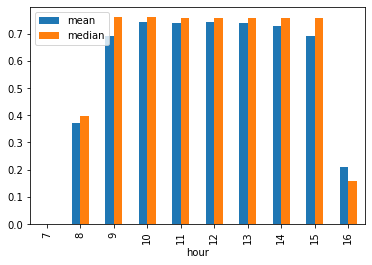

In [48]:
# after 4pm was a problem in December, how is it now?

print('HOW EACH HOUR COMPARES FOR PERCENTAGE TIME THAT DEVICE IS RUNNING CORRECTLY (GRAPH)')

ax = sel.plot(kind = 'bar')

# 4pm improved a lot since December but is still poor. 8am isn't great either

In [49]:
# Now are there any potential outliers?

dfpre.max()

date_time          2021-01-29 23:00:00
day                          Wednesday
hour                                23
date_of_month                       31
pct_up                           0.791
pedestrian_ab                       35
pedestrian_ba                       54
ped_all                             54
bike_ab                             38
bike_ba                             52
bike_all                            52
car_ab                              92
car_ba                              19
car_all                             92
big_veh_ab                          13
big_veh_ba                          13
big_veh_all                         13
car_speed_010k                     100
car_speed_1020k                    100
car_speed_2030k                    100
car_speed_3040k                    100
car_speed_4050k                    100
car_speed_5060k                     50
car_speed_6070k                    100
car_speed_7080k                    100
date_time_str         31-

In [29]:
# how do the potential outliers look like without 4pm +?

dfpre[dfpre.hour != 16].max()

date_time          2021-01-26 15:00:00
day                          Wednesday
hour                                15
date_of_month                       31
pct_up                           0.791
pedestrian_ab                       23
pedestrian_ba                       13
ped_all                             25
bike_ab                             37
bike_ba                             18
bike_all                            38
car_ab                              41
car_ba                              18
car_all                             41
big_veh_ab                          13
big_veh_ba                          13
big_veh_all                         13
car_speed_010k                     100
car_speed_1020k                    100
car_speed_2030k                    100
car_speed_3040k                    100
car_speed_4050k                    100
car_speed_5060k                     50
car_speed_6070k                    100
car_speed_7080k                     50
date_time_str         31-

In [51]:
# what's happening with a pedestrian value of 54? 

dfpre[dfpre.pedestrian_ba == 54]

# Everyone going in one direction, after 4pm. Better dumped.

,date_time,day,hour,date_of_month,pct_up,pedestrian_ab,pedestrian_ba,ped_all,bike_ab,bike_ba,bike_all,car_ab,car_ba,car_all,big_veh_ab,big_veh_ba,big_veh_all,car_speed_010k,car_speed_1020k,car_speed_2030k,car_speed_3040k,car_speed_4050k,car_speed_5060k,car_speed_6070k,car_speed_7080k,date_time_str
245,2020-12-11 16:00:00,Friday,16,11,0.055,0,54,54,0,18,18,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11-12-2020 16:00


In [66]:
# build df only from 8am to 5pm

# list of hours when no data is gathered
off_hours = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7]

# df with only active hours
df = dfpre[~dfpre.hour.isin(off_hours) == True]


In [67]:
df.head(6)

,date_time,day,hour,date_of_month,pct_up,pedestrian_ab,pedestrian_ba,ped_all,bike_ab,bike_ba,bike_all,car_ab,car_ba,car_all,big_veh_ab,big_veh_ba,big_veh_all,car_speed_010k,car_speed_1020k,car_speed_2030k,car_speed_3040k,car_speed_4050k,car_speed_5060k,car_speed_6070k,car_speed_7080k,date_time_str
0,2020-12-01 11:00:00,Tuesday,11,1,0.512,2,2,4,8,6,14,16,4,20,0,0,0,30.00,50.00,10.00,10.00,0.00,0.00,0.0,0.00,01-12-2020 11:00
1,2020-12-01 12:00:00,Tuesday,12,1,0.758,1,4,5,12,4,16,21,11,32,0,0,0,8.33,33.33,37.50,12.50,4.17,4.17,0.0,0.00,01-12-2020 12:00
2,2020-12-01 13:00:00,Tuesday,13,1,0.770,1,5,6,14,4,18,17,9,26,0,0,0,10.00,30.00,25.00,30.00,5.00,0.00,0.0,0.00,01-12-2020 13:00
3,2020-12-01 14:00:00,Tuesday,14,1,0.769,3,5,8,3,5,8,8,12,20,0,0,0,6.67,26.67,46.67,6.67,6.67,0.00,0.0,6.67,01-12-2020 14:00
4,2020-12-01 15:00:00,Tuesday,15,1,0.644,6,2,8,3,6,9,6,5,11,0,0,0,0.00,28.57,57.14,14.29,0.00,0.00,0.0,0.00,01-12-2020 15:00
21,2020-12-02 08:00:00,Wednesday,8,2,0.357,3,3,6,11,3,14,17,11,28,0,0,0,20.00,20.00,40.00,10.00,0.00,0.00,0.0,10.00,02-12-2020 08:00


In [68]:
# remove the 5 hours of the partial first day (it only starts at 11), not at 8 

df = df[5:]

In [69]:
df.shape

(472, 26)

In [70]:
# check - it looks like we have the same number of hours each day

df.hour.value_counts()

15    59
14    59
13    59
12    59
11    59
10    59
9     59
8     59
Name: hour, dtype: int64

## adjust for only full weeks

In [71]:
# we don't have only full weeks - there are a few extra days at the end. If we start on a Weds at 8am, we should finish
# on a Tuesday with a 4pm reading

df[-30:]

,date_time,day,hour,date_of_month,pct_up,pedestrian_ab,pedestrian_ba,ped_all,bike_ab,bike_ba,bike_all,car_ab,car_ba,car_all,big_veh_ab,big_veh_ba,big_veh_all,car_speed_010k,car_speed_1020k,car_speed_2030k,car_speed_3040k,car_speed_4050k,car_speed_5060k,car_speed_6070k,car_speed_7080k,date_time_str
1339,2021-01-26 10:00:00,Tuesday,10,26,0.775,1,0,1,5,1,6,1,4,5,0,0,0,0.00,25.00,25.00,25.00,25.00,0.00,0.00,0.00,26-01-2021 10:00
1340,2021-01-26 11:00:00,Tuesday,11,26,0.759,0,0,0,4,1,5,9,1,11,3,0,3,12.50,12.50,25.00,25.00,25.00,0.00,0.00,0.00,26-01-2021 11:00
1341,2021-01-26 12:00:00,Tuesday,12,26,0.758,1,0,1,0,3,3,5,5,11,1,1,3,25.00,0.00,12.50,50.00,12.50,0.00,0.00,0.00,26-01-2021 12:00
1342,2021-01-26 13:00:00,Tuesday,13,26,0.766,3,1,4,9,4,13,1,4,5,1,1,3,0.00,0.00,50.00,50.00,0.00,0.00,0.00,0.00,26-01-2021 13:00
1343,2021-01-26 14:00:00,Tuesday,14,26,0.757,0,3,3,0,3,3,5,3,8,0,0,0,0.00,16.67,66.67,16.67,0.00,0.00,0.00,0.00,26-01-2021 14:00
1344,2021-01-26 15:00:00,Tuesday,15,26,0.763,0,3,3,5,1,7,7,1,8,0,0,0,0.00,16.67,66.67,0.00,0.00,16.67,0.00,0.00,26-01-2021 15:00
1361,2021-01-27 08:00:00,Wednesday,8,27,0.178,11,0,11,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27-01-2021 08:00
1362,2021-01-27 09:00:00,Wednesday,9,27,0.765,5,1,7,3,1,4,3,7,9,1,0,1,14.29,0.00,14.29,28.57,28.57,14.29,0.00,0.00,27-01-2021 09:00
1363,2021-01-27 10:00:00,Wednesday,10,27,0.766,5,0,5,1,1,3,1,1,3,1,1,3,50.00,0.00,50.00,0.00,0.00,0.00,0.00,0.00,27-01-2021 10:00
1364,2021-01-27 11:00:00,Wednesday,11,27,0.712,1,0,1,3,1,4,4,4,8,0,3,3,0.00,0.00,83.33,16.67,0.00,0.00,0.00,0.00,27-01-2021 11:00


In [76]:
# remove the last 24 rows and check

df = df[:-24]

df[-5:]

,date_time,day,hour,date_of_month,pct_up,pedestrian_ab,pedestrian_ba,ped_all,bike_ab,bike_ba,bike_all,car_ab,car_ba,car_all,big_veh_ab,big_veh_ba,big_veh_all,car_speed_010k,car_speed_1020k,car_speed_2030k,car_speed_3040k,car_speed_4050k,car_speed_5060k,car_speed_6070k,car_speed_7080k,date_time_str
1340,2021-01-26 11:00:00,Tuesday,11,26,0.759,0,0,0,4,1,5,9,1,11,3,0,3,12.5,12.50,25.00,25.00,25.0,0.00,0.0,0.0,26-01-2021 11:00
1341,2021-01-26 12:00:00,Tuesday,12,26,0.758,1,0,1,0,3,3,5,5,11,1,1,3,25.0,0.00,12.50,50.00,12.5,0.00,0.0,0.0,26-01-2021 12:00
1342,2021-01-26 13:00:00,Tuesday,13,26,0.766,3,1,4,9,4,13,1,4,5,1,1,3,0.0,0.00,50.00,50.00,0.0,0.00,0.0,0.0,26-01-2021 13:00
1343,2021-01-26 14:00:00,Tuesday,14,26,0.757,0,3,3,0,3,3,5,3,8,0,0,0,0.0,16.67,66.67,16.67,0.0,0.00,0.0,0.0,26-01-2021 14:00
1344,2021-01-26 15:00:00,Tuesday,15,26,0.763,0,3,3,5,1,7,7,1,8,0,0,0,0.0,16.67,66.67,0.00,0.0,16.67,0.0,0.0,26-01-2021 15:00


In [78]:
# check we have same number of days

df.day.value_counts()

# 9h on each day, 8 weeks, so 72 occurances of Monday (and of Tuesday etc)

Thursday     64
Sunday       64
Saturday     64
Tuesday      64
Wednesday    64
Friday       64
Monday       64
Name: day, dtype: int64

In [77]:
# 8 weeks of 7 days, with 8 hours a day

print(8 * 7 * 8)

df.shape

448


(448, 26)

## afterthought - add a 'month' column

In [79]:
# add a col with just month

df['month'] = df.date_time.dt.month
    

> Note: Although there are two 'months' with the data running from early December to late January, months are not worth it since they're completely dissimilar

In [302]:
# the two months aren't even in size

vol_dec = len(df[df['date_time'].dt.month == 12])
vol_jan = len(df[df['date_time'].dt.month == 1])
print('dec:', vol_dec, 'jan:', vol_jan)

dec: 240 jan: 208


In [80]:
# show the average bike count per instances of month (= total bikes / nb of days in the month)

df.groupby([df['date_time'].dt.month]).bike_all.sum()


date_time
1     1336
12    2004
Name: bike_all, dtype: int64

<a id='bikes'></a>
<div class="alert alert-success">

## bicycles

</div>

## hours

In [102]:
# what numbers do we have on the 'all bikes' column? (an observation is an hour)

numbers = ['sum', 'mean', 'median', 'std', 'var', 'max', 'min']

bikes = df.bike_all.agg(numbers)

for a, b in zip(numbers, bikes):
    print(a, int(b))


sum 3340
mean 7
median 7
std 5
var 29
max 38
min 0


In [103]:
# what 'number of bikes an hour' count is most common? 4 bikes an hour

df.bike_all.value_counts().sort_values(ascending = False).head(10)

average hourly count of bikes: 7.455357142857143


4     53
5     39
8     35
3     34
7     34
9     33
0     30
1     27
12    26
13    24
Name: bike_all, dtype: int64

In [113]:
# what was the busiest hour for bikes?

bikes = df.bike_all.max()
print(bikes)

# how frequent are the bikes?

nb_minutes = 60 * 60
frequency_secs = int(nb_minutes / bikes)
print('a bike every', frequency_secs, 'seconds')

# check - should make 60 mins
(38 * 94) / 60

38
a bike every 94 seconds


59.53333333333333

In [114]:
# when did this happen? - on NY eve, a Thursday, at 11am

df[df.bike_all == 38]

,date_time,day,hour,date_of_month,pct_up,pedestrian_ab,pedestrian_ba,ped_all,bike_ab,bike_ba,bike_all,car_ab,car_ba,car_all,big_veh_ab,big_veh_ba,big_veh_all,car_speed_010k,car_speed_1020k,car_speed_2030k,car_speed_3040k,car_speed_4050k,car_speed_5060k,car_speed_6070k,car_speed_7080k,date_time_str,month
720,2020-12-31 11:00:00,Thursday,11,31,0.761,1,3,4,37,1,38,9,5,14,4,1,5,9.09,27.27,18.18,18.18,0.0,9.09,9.09,9.09,31-12-2020 11:00,12


<AxesSubplot:xlabel='hour'>

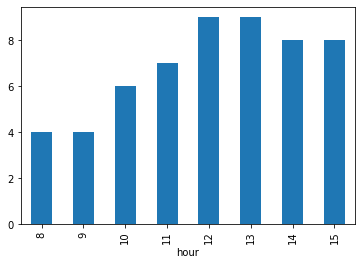

In [115]:
# how do the hours compare in terms of bike business? Lunchtime, unsurprisingly

df.groupby('hour')['bike_all'].median().round(0).plot.bar()

In [309]:
# how many times in the 448 hourly observations do we have 0 bikes? Only 30 times out of about 450

len(df[df.bike_all == 0])

30

In [116]:
# how many times in the 448 hourly observations do we have 0 cars? Only 30 times out of about 450

len(df[df.car_all == 0])

30

In [117]:
447 / 30

14.9

In [118]:
# what days do you find hours with no cars? (Fridays for bikes)

df[df.car_all == 0].day.value_counts()

Sunday       8
Monday       7
Wednesday    5
Saturday     4
Friday       3
Thursday     2
Tuesday      1
Name: day, dtype: int64

In [119]:
# what times do you find hours with no cars? (also 8am for bikes)

df[df.car_all == 0].hour.value_counts()

8     20
9      6
15     3
10     1
Name: hour, dtype: int64

## Is there an hour with more bikes than cars? - yes, more than a quarter of the time

In [120]:
# create col showing how many more cars there are than bikes per hours

df['diff_bike_car'] = df.car_all - df.bike_all


In [121]:
# create selection for any hours where there are more bikes than cars

diff = df[df.diff_bike_car <0][['date_time', 'day', 'bike_all', 'car_all', 'diff_bike_car']]

In [122]:
# how many instances of this?

len(diff)

126

In [123]:
# what percentage of the main df is 126?

(126/448)*100

28.125

In [127]:
# use unlimited rows and cells JUST for THIS col and show the instances of more bikes than cars

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(diff)


               date_time        day  bike_all  car_all  diff_bike_car
24   2020-12-02 11:00:00  Wednesday        17        9             -8
45   2020-12-03 08:00:00   Thursday        19       11             -8
93   2020-12-05 08:00:00   Saturday         5        0             -5
95   2020-12-05 10:00:00   Saturday        24       13            -11
117  2020-12-06 08:00:00     Sunday         4        0             -4
122  2020-12-06 13:00:00     Sunday        16       10             -6
124  2020-12-06 15:00:00     Sunday        13        9             -4
141  2020-12-07 08:00:00     Monday         7        4             -3
143  2020-12-07 10:00:00     Monday         9        8             -1
168  2020-12-08 11:00:00    Tuesday         9        8             -1
169  2020-12-08 12:00:00    Tuesday        15        9             -6
189  2020-12-09 08:00:00  Wednesday        12       10             -2
193  2020-12-09 12:00:00  Wednesday        17       13             -4
218  2020-12-10 13:0

In [128]:
diff

,date_time,day,bike_all,car_all,diff_bike_car
24,2020-12-02 11:00:00,Wednesday,17,9,-8
45,2020-12-03 08:00:00,Thursday,19,11,-8
93,2020-12-05 08:00:00,Saturday,5,0,-5
95,2020-12-05 10:00:00,Saturday,24,13,-11
117,2020-12-06 08:00:00,Sunday,4,0,-4
...,...,...,...,...,...
1295,2021-01-24 14:00:00,Sunday,5,4,-1
1296,2021-01-24 15:00:00,Sunday,12,4,-8
1313,2021-01-25 08:00:00,Monday,6,4,-2
1339,2021-01-26 10:00:00,Tuesday,6,5,-1


In [129]:
# add vans and get the diff not just with cars but cars AND vans

df['diff_bike_cv'] = (df.car_all + df.big_veh_all) - df.bike_all

In [130]:
# build selection only where bikes outnumbers cars + big vehicles

diff_cv = df[df.diff_bike_cv <0][['date_time', 'day', 'bike_all', 'car_all', 'big_veh_all', 'diff_bike_car']]

In [132]:
print(len(diff_cv))

diff_cv

92


,date_time,day,bike_all,car_all,big_veh_all,diff_bike_car
24,2020-12-02 11:00:00,Wednesday,17,9,0,-8
45,2020-12-03 08:00:00,Thursday,19,11,0,-8
93,2020-12-05 08:00:00,Saturday,5,0,0,-5
95,2020-12-05 10:00:00,Saturday,24,13,0,-11
117,2020-12-06 08:00:00,Sunday,4,0,0,-4
...,...,...,...,...,...,...
1271,2021-01-23 14:00:00,Saturday,9,6,1,-3
1292,2021-01-24 11:00:00,Sunday,5,3,0,-2
1296,2021-01-24 15:00:00,Sunday,12,4,3,-8
1339,2021-01-26 10:00:00,Tuesday,6,5,0,-1


In [133]:
# what percentage of the main df is 126?

(92/448)*100

20.535714285714285

## days

In [135]:
df.groupby('day')['bike_all'].sum().sort_values(ascending = False)

# total counts of bikes by day - this'll give hourly averages once you divide by 8 hours and by 8 weeks


day
Saturday     608
Thursday     565
Friday       487
Tuesday      457
Wednesday    446
Monday       439
Sunday       338
Name: bike_all, dtype: int64

In [136]:
# daily average for Saturdays

608 / 8

76.0

In [137]:
# hourly average for Saturdays

608 / 64

9.5

In [140]:
df.groupby('day')['bike_all'].mean().sort_values(ascending = False)

# now at 8 weeks, Saturday has the busiest average hour and Sunday quietest

day
Saturday     9.500
Thursday     8.828
Friday       7.609
Tuesday      7.141
Wednesday    6.969
Monday       6.859
Sunday       5.281
Name: bike_all, dtype: float64

In [141]:
# much change with median?

df.groupby('day')['bike_all'].median().sort_values(ascending = False)

day
Thursday     9.0
Saturday     9.0
Tuesday      7.0
Wednesday    6.5
Friday       6.0
Monday       5.5
Sunday       4.0
Name: bike_all, dtype: float64

<AxesSubplot:xlabel='day'>

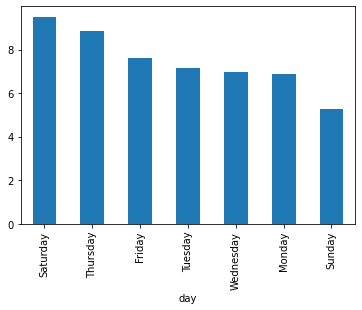

In [142]:
df.groupby('day')['bike_all'].mean().sort_values(ascending = False).plot.bar()

In [144]:
# but it wasn't a Saturday that had the busiest hour - that was a NYE Thursday (as seen above)

df.groupby('day')['bike_all'].max().sort_values(ascending = False)


day
Thursday     38
Monday       34
Friday       26
Tuesday      25
Saturday     24
Wednesday    17
Sunday       16
Name: bike_all, dtype: int64

In [146]:
# are saturdays the busiest in each of the 8 weeks? Not always 

df.groupby(['month', 'date_of_month', 'day'])[['day', 'bike_all']].sum().sort_values(['month', 'date_of_month'], ascending = (False, True))

# how many weeks had Sat as busiest day? 1, 2, 3, 7, 8

bike_all
month date_of_month day                
12    2             Wednesday        83
      3             Thursday         85
      4             Friday           67
      5             Saturday        101
      6             Sunday           65
      7             Monday           59
      8             Tuesday          74
      9             Wednesday        83
      10            Thursday         72
      11            Friday           92
      12            Saturday        122
      13            Sunday           51
      14            Monday           66
      15            Tuesday          97
      16            Wednesday        51
      17            Thursday         84
      18            Friday           82
      19            Saturday        111
      20            Sunday           30
      21            Monday           57
      22            Tuesday          43
      23            Wednesday        27
      24            Thursday         67
      25            Friday           27
      26            Saturday         24
      27            Sunday           32
      28            Monday           48
      29            Tuesday          61
      30            Wednesday        50
      31            Thursday         93
1     1             Friday           37
      2             Saturday         41
      3             Sunday           39
      4             Monday           58
      5             Tuesday          49
      6             Wednesday        53
      7             Thursday         39
      8             Friday           49
      9             Saturday         57
      10            Sunday           40
      11            Monday           66
      12            Tuesday          37
      13            Wednesday        42
      14            Thursday         56
      15            Friday           69
      16            Saturday         75
      17            Sunday           49
      18            Monday           50
      19            Tuesday          51
      20            Wednesday        57
      21            Thursday         69
      22            Friday           64
      23            Saturday         77
      24            Sunday           32
      25            Monday           35
      26            Tuesday          45

In [361]:
# same selection but sorted for busiest days

df.groupby(['month', 'date_of_month', 'day'])[['day', 'bike_all']].sum().sort_values(['bike_all'], ascending = (False))

# how many weeks had Sat as busiest day? 1, 2, 3, 7, 8


bike_all
month date_of_month day                
12    12            Saturday        122
      19            Saturday        111
      5             Saturday        101
      15            Tuesday          97
      31            Thursday         93
      11            Friday           92
      3             Thursday         85
      17            Thursday         84
      2             Wednesday        83
      9             Wednesday        83
      18            Friday           82
1     23            Saturday         77
      16            Saturday         75
12    8             Tuesday          74
      10            Thursday         72
1     21            Thursday         69
      15            Friday           69
12    24            Thursday         67
      4             Friday           67
1     11            Monday           66
12    14            Monday           66
      6             Sunday           65
1     22            Friday           64
12    29            Tuesday          61
      7             Monday           59
1     4             Monday           58
      20            Wednesday        57
12    21            Monday           57
1     9             Saturday         57
      14            Thursday         56
      6             Wednesday        53
12    16            Wednesday        51
1     19            Tuesday          51
12    13            Sunday           51
      30            Wednesday        50
1     18            Monday           50
      8             Friday           49
      17            Sunday           49
      5             Tuesday          49
12    28            Monday           48
1     26            Tuesday          45
12    22            Tuesday          43
1     13            Wednesday        42
      2             Saturday         41
      10            Sunday           40
      3             Sunday           39
      7             Thursday         39
      1             Friday           37
      12            Tuesday          37
      25            Monday           35
12    27            Sunday           32
1     24            Sunday           32
12    20            Sunday           30
      23            Wednesday        27
      25            Friday           27
      26            Saturday         24

## weeks

In [154]:
# new df with datetime col as index

dfi = df.set_index('date_time')

In [245]:
dfi[-3:]

,day,hour,date_of_month,pct_up,pedestrian_ab,pedestrian_ba,ped_all,bike_ab,bike_ba,bike_all,car_ab,car_ba,car_all,big_veh_ab,big_veh_ba,big_veh_all,car_speed_010k,car_speed_1020k,car_speed_2030k,car_speed_3040k,car_speed_4050k,car_speed_5060k,car_speed_6070k,car_speed_7080k,date_time_str,month,diff_bike_car,diff_bike_cv
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-26 13:00:00,Tuesday,13,26,0.766,3,1,4,9,4,13,1,4,5,1,1,3,0.0,0.00,50.00,50.00,0.0,0.00,0.0,0.0,26-01-2021 13:00,1,-8,-5
2021-01-26 14:00:00,Tuesday,14,26,0.757,0,3,3,0,3,3,5,3,8,0,0,0,0.0,16.67,66.67,16.67,0.0,0.00,0.0,0.0,26-01-2021 14:00,1,5,5
2021-01-26 15:00:00,Tuesday,15,26,0.763,0,3,3,5,1,7,7,1,8,0,0,0,0.0,16.67,66.67,0.00,0.0,16.67,0.0,0.0,26-01-2021 15:00,1,1,1


In [171]:
# group by week, and get an average for that week

hr_av_byweek = dfi.resample('W')[['bike_all', 'car_all']].mean().round(1)

hr_av_byweek

,bike_all,car_all
date_time,,
2020-12-06,10.0,15.9
2020-12-13,9.9,12.4
2020-12-20,9.3,11.7
2020-12-27,4.9,7.9
2021-01-03,6.6,7.1
2021-01-10,6.2,7.6
2021-01-17,7.0,7.6
2021-01-24,7.1,8.5
2021-01-31,5.0,7.6


## fix this -- the week has a default start date that needs adjusting

In [332]:
# set the day as the CLOSING day of the week

total_byweek = dfi.resample('W-TUE')[['bike_all', 'car_all']].sum().round(3)

total_byweek

,bike_all,car_all
date_time,,
2020-12-08,534,833
2020-12-15,583,728
2020-12-22,458,558
2020-12-29,286,419
2021-01-05,367,380
2021-01-12,341,449
2021-01-19,392,423
2021-01-26,379,484


In [291]:
# CHECK what we're looking at - rebuild by groupby - look at first week of dec and get the daily sum

df.groupby(['month','date_of_month'])['bike_all', 'car_all'].sum()[26:33]

bike_all  car_all
month date_of_month                   
12    2                    83      150
      3                    85      151
      4                    67      129
      5                   101      140
      6                    65       66
      7                    59      114
      8                    74       83

In [293]:
# this is what's generating our resample figure - so, weekly totals

df.groupby(['month','date_of_month'])['bike_all', 'car_all'].sum()[26:33].sum()

bike_all    534
car_all     833
dtype: int64

In [340]:
# make a straight df without date index at this stage for plotting

total_byweek_o = total_byweek.reset_index()

# drop the old datetime col

total_byweek_o = total_byweek_o.iloc[:, 1:]


,bike_all,car_all
0,534,833
1,583,728
2,458,558
3,286,419
4,367,380
5,341,449
6,392,423
7,379,484


In [345]:
total_byweek_o

,bike_all,car_all
0,534,833
1,583,728
2,458,558
3,286,419
4,367,380
5,341,449
6,392,423
7,379,484


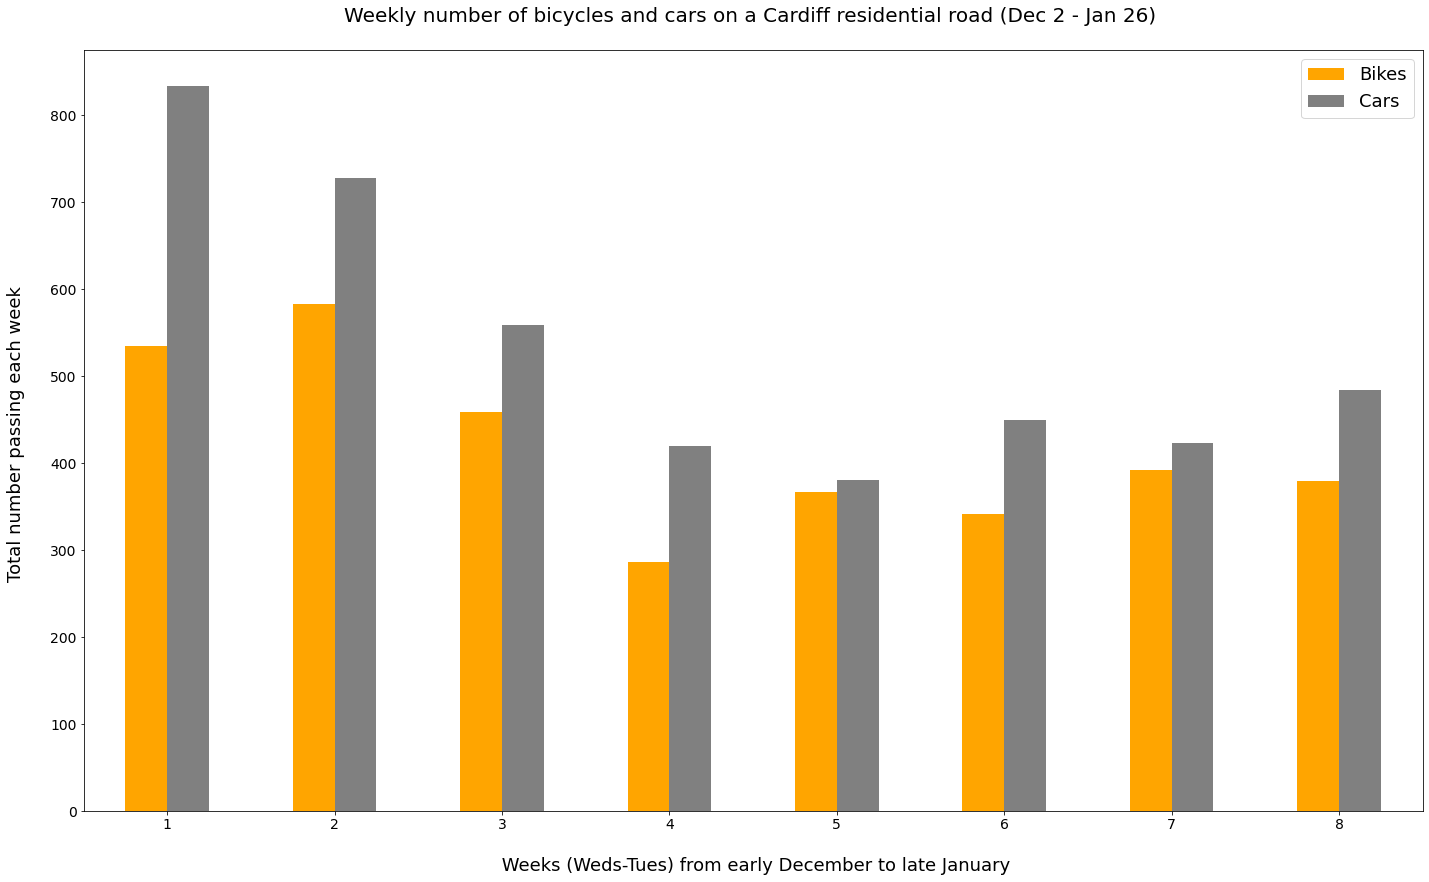

In [357]:
# plot

plt.plot = total_byweek_o.plot.bar(figsize=(24, 14), color = ["orange", "grey"])

this_title = 'Weekly number of bicycles and cars on a Cardiff residential road (Dec 2 - Jan 26) \n'
plt.title(this_title, fontsize = 20)

plt.legend(['Bikes', 'Cars'], loc='best', fontsize = 18)

plt.ylabel("Total number passing each week \n", fontsize = 18)
plt.yticks(fontsize = 14)

my_ticks = [0, 1, 2, 3, 4, 5, 6, 7]
my_labels = [1, 2, 3, 4, 5, 6, 7, 8]
plt.xlabel("\n Weeks (Weds-Tues) from early December to late January", fontsize = 18)
plt.xticks(ticks = my_ticks, labels = my_labels, fontsize = 14, rotation = 'horizontal')

plt.savefig('bikes_cars_total.png', dpi=fig.dpi)
plt.show()

<a id='method'></a>
<div class="alert alert-success">

## methodology notes

</div>

> General info: https://telraam.zendesk.com/hc/en-us/sections/360004034152-General-questions-about-Telraam

> On the pct_up: https://telraam.zendesk.com/hc/en-us/articles/360027325572-Want-more-data-Telraam-API:

> “pct_up” gives the percentage of time (between 0 and 1 –> 0% to 100%) the Telraam camera was actively counting traffic in the one hour interval. This is almost never 1 (100%), because in standard operation background calculation intervals break the continuous measurements every couple of minutes for a half minute, and during the background calculation no active measurements are being carried out. So a typical good value is around 0.75+/- 0.05. We correct for this typically ~25% downtime by multiplying the actually measured traffic volumes with an appropriate correction factor to estimate the amount of traffic we would have observed given a 100% uptime. These corrected volumes are reported below (rounded to the closest integer). **The values “Pedestrian” – “Bike” – “Car” – “Lorry” contain therefore the corrected traffic volumes for this hour.**

> Vans can either be counted as trucks or cars, depending on their size. A user wrote:

> "According to my Telraam, cars drive faster than 70km/h in my street, but that's not possible physically. Is my Telraam not working?" Yes, but there are so-called outliers; measurements in which something has gone wrong. We don't filter for these errors. If you suspect that there is a problem with the speed measurements, report it to the Telraam-Team. / "Is my Telraam a speed camera after all?" No, certainly not. Your Telraam cannot make a statement about the (calibrated) speed of individual cars. The measurement error can be large at the level of individual vehicles, but that error can be in both directions (faster or slower than in reality). **This error corrects itself at the level of a group of cars, as there are more measurements. Telraam can therefore give you an idea about the speed regime of a large number of cars.**